In [1]:
import torch
from gpzoo.gp import VNNGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import GaussianLikelihood
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn, distributions, optim
from tqdm.autonotebook import tqdm
import numpy as np
import time


/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm

Bad key text.latex.preview in file /opt/anaconda3/envs/research/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/envs/research/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matp

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def make_data(D=4, N=50):
  X = Normal(0, 1.0).sample((N,))*10
  Y = torch.zeros((D, N))
  for i in range(D):
    Y[i] = (i+1)*torch.sin(2**(i-1)*X) + Normal(0, 0.1).sample((N,))
  return X,Y

In [4]:
X, Y = make_data(D=3, N=400)
print(X.shape)
print(Y.shape)

torch.Size([400])
torch.Size([3, 400])


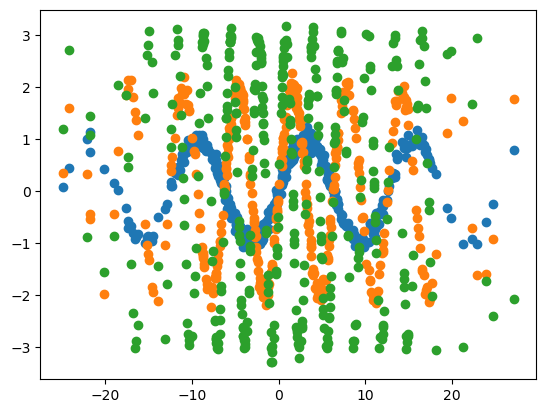

In [5]:
%matplotlib inline
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(X, Y[i])

plt.show()

In [6]:
def train(model, optimizer, X, y, device, steps=200, E=20, lkzz_build=0, **kwargs):
    losses = []

    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, verbose=False, lkzz_build=lkzz_build, **kwargs)

        logpY = pY.log_prob(y)
        #print("Shape of y:", y.shape)
        #print("Expected shape by model output:", pY.mean.shape)  # Assuming pY is a distribution

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [7]:
torch.manual_seed(21)
X, Y = make_data(D=3, N=5000)
X = X[:, None]

# initialize dictionary
L = 3
M = 1000

dx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
#gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST

# update data dictionary
model = GaussianLikelihood(gp=gp, noise=0.1)
model.to(device)
X_train = X.to(device)
Y_train = Y.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

model.to(device)
start_time = time.time()
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=100, E=10)
end_time = time.time()
final_time = end_time - start_time

# save losses
fig1, ax1 = plt.subplots()
plt.plot(losses)

# save test figure
model.cpu()
X_test= torch.linspace(-30, 30, 2000)[:, None]
qF, qU, pU = model.gp(X_test)

fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
for j in range(3):
  ax = ax2[j] 
  mean = qF.mean.detach().cpu().numpy()[j]
  sd = qF.scale.detach().cpu().numpy()[j]
  ax.plot(X_test, mean)
  ax.scatter(X, Y[j], alpha=0.5)
  ax.fill_between(
            X_test[:, 0], 
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
  ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))



  0%|          | 0/100 [00:00<?, ?it/s]

Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
